# Intro

**The main goal** For this notebook is to use a multi-class approach to predict the the outcomes of patients with cirrhosis.

### About Dataset

Utilize 17 clinical features for predicting survival state of patients with liver cirrhosis. The survival states include `0 = D (death)`, `1 = C (censored)`, `2 = CL (censored due to liver transplantation)`.


**For what purpose was the dataset created?**

Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption. The data provided is sourced from a Mayo Clinic study on primary biliary cirrhosis (PBC) of the liver carried out from 1974 to 1984.

**Who funded the creation of the dataset?**

Mayo Clinic

**What do the instances in this dataset represent?**

People

**Does the dataset contain data that might be considered sensitive in any way?**

Gender, Age

**Was there any data preprocessing performed?**

1. Drop all the rows where miss value (NA) were present in the Drug column
2. Impute missing values with mean results
3. One-hot encoding for all category attributes

**Additional Information**

During 1974 to 1984, 424 PBC patients referred to the Mayo Clinic qualified for the randomized placebo-controlled trial testing the drug D-penicillamine. Of these, the initial 312 patients took part in the trial and have mostly comprehensive data. The remaining 112 patients didn't join the clinical trial but agreed to record basic metrics and undergo survival tracking. Six of these patients were soon untraceable after their diagnosis, leaving data for 106 of these individuals in addition to the 312 who were part of the randomized trial.



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv
/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


# Load Packages

In [2]:
import optuna
import warnings 
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer

import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss

sns.set_style('darkgrid')
%matplotlib inline

# Load Data

In [3]:
# Load the competition's data
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')

train.shape, test.shape

((7905, 20), (5271, 19))

In [4]:
# Load the original dataset
org_data = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')
org_data.shape

(418, 20)

In [5]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [6]:
org_data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [7]:
# Drop the 'id' column 
train = train.drop(['id'], axis=1)
org_data = org_data.drop(['ID'], axis=1)

# Combine the competition train data and original data
train_data = pd.concat([train, org_data])

# Exploratory Data Analysis (EDA)

In [8]:
train_data.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [9]:
# The shape of dataset

m, n = train_data.shape
print('Number of rows in dataset : ', m)
print('Number of columns in dataset : ', n)

Number of rows in dataset :  8323
Number of columns in dataset :  19


In [10]:
FEATURES = train_data.drop(['Status'], axis=1).columns
FEATURES

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage'],
      dtype='object')

In [11]:
# Let’s get a quick summary of the dataset 
train_data.describe(include='all')

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
count,8323.000000,8217,8323.000000,8323,8217,8217,8217,8323,8323.000000,8189.000000,8323.000000,8215.000000,8217.000000,8217.000000,8187.000000,8312.000000,8321.000000,8317.000000,8323
unique,NaN,2,NaN,2,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,Placebo,NaN,F,N,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
freq,NaN,4164,NaN,7710,7813,4202,6188,7515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5197
mean,2024.528776,NaN,18381.192359,NaN,NaN,NaN,NaN,NaN,2.625940,351.219074,3.545767,84.421546,1823.044883,114.906530,115.662636,264.827238,10.634575,3.032103,NaN
std,1094.968696,NaN,3686.832308,NaN,NaN,NaN,NaN,NaN,3.847146,196.775246,0.350697,76.327480,1913.388685,49.134067,53.037660,88.039809,0.795707,0.867235,NaN
min,41.000000,NaN,9598.000000,NaN,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000,NaN
25%,1220.000000,NaN,15574.000000,NaN,NaN,NaN,NaN,NaN,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,210.000000,10.000000,2.000000,NaN
50%,1831.000000,NaN,18713.000000,NaN,NaN,NaN,NaN,NaN,1.100000,299.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,264.000000,10.600000,3.000000,NaN
75%,2689.000000,NaN,20684.000000,NaN,NaN,NaN,NaN,NaN,3.000000,392.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000,NaN


In [12]:
# Let’s also see the columns and their data types
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8323 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         8323 non-null   int64  
 1   Drug           8217 non-null   object 
 2   Age            8323 non-null   int64  
 3   Sex            8323 non-null   object 
 4   Ascites        8217 non-null   object 
 5   Hepatomegaly   8217 non-null   object 
 6   Spiders        8217 non-null   object 
 7   Edema          8323 non-null   object 
 8   Bilirubin      8323 non-null   float64
 9   Cholesterol    8189 non-null   float64
 10  Albumin        8323 non-null   float64
 11  Copper         8215 non-null   float64
 12  Alk_Phos       8217 non-null   float64
 13  SGOT           8217 non-null   float64
 14  Tryglicerides  8187 non-null   float64
 15  Platelets      8312 non-null   float64
 16  Prothrombin    8321 non-null   float64
 17  Stage          8317 non-null   float64
 18  Status        

In [13]:
# Number of Duplicated Rows 
train_data.duplicated().sum()

0

#### Let's show the counts of observations in each categorical bin using bars.

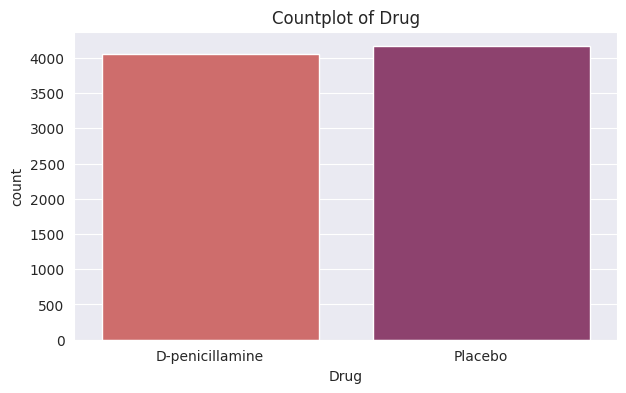

In [14]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Drug', data = train_data, palette = 'flare')
plt.title('Countplot of Drug')
plt.show()

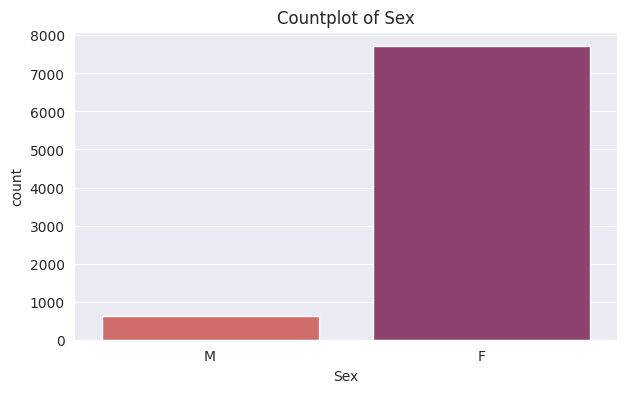

In [15]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Sex', data = train_data, palette = 'flare')
plt.title('Countplot of Sex')
plt.show()

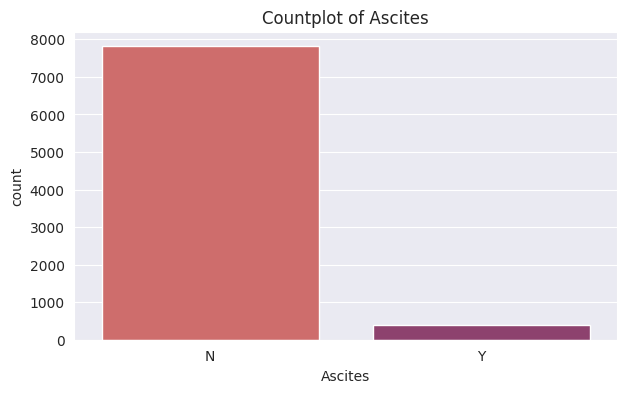

In [16]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Ascites', data = train_data, palette = 'flare')
plt.title('Countplot of Ascites')
plt.show()

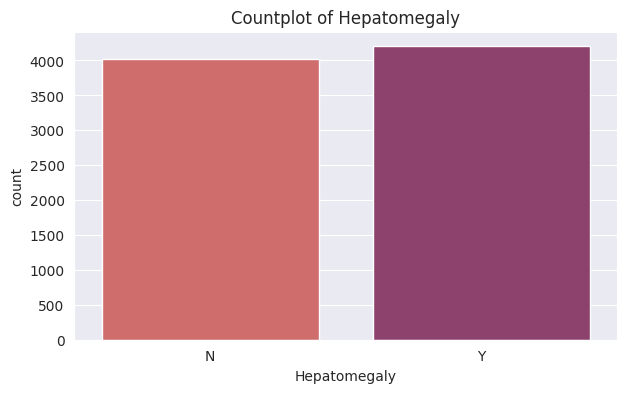

In [17]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Hepatomegaly', data = train_data, palette = 'flare')
plt.title('Countplot of Hepatomegaly')
plt.show()

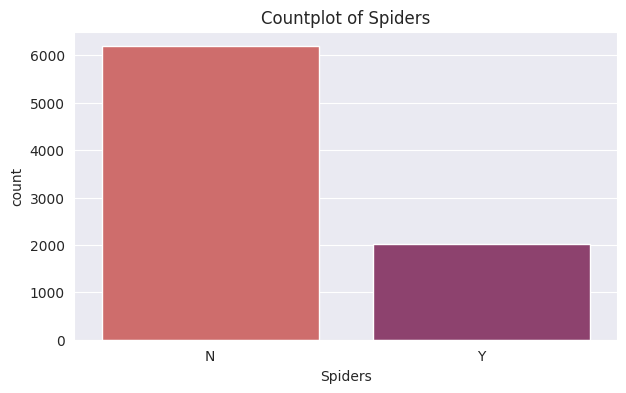

In [18]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Spiders', data = train_data, palette = 'flare')
plt.title('Countplot of Spiders')
plt.show()

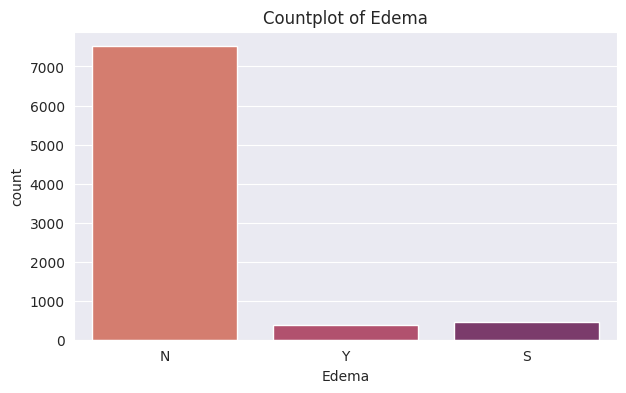

In [19]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Edema', data = train_data, palette = 'flare')
plt.title('Countplot of Edema')
plt.show()

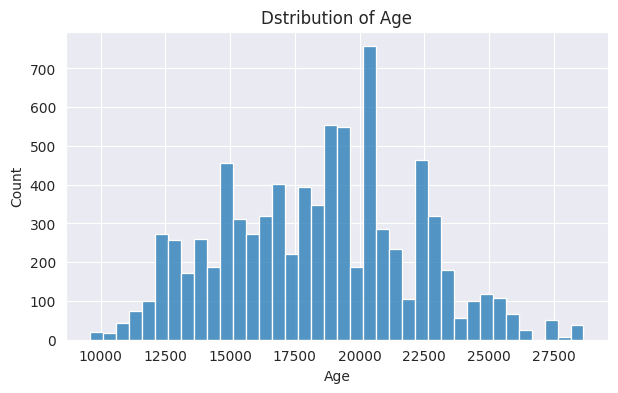

In [20]:
plt.figure(figsize=(7, 4))
sns.histplot(x ='Age', data = train_data)
plt.title('Dstribution of Age')
plt.show()

### Target column

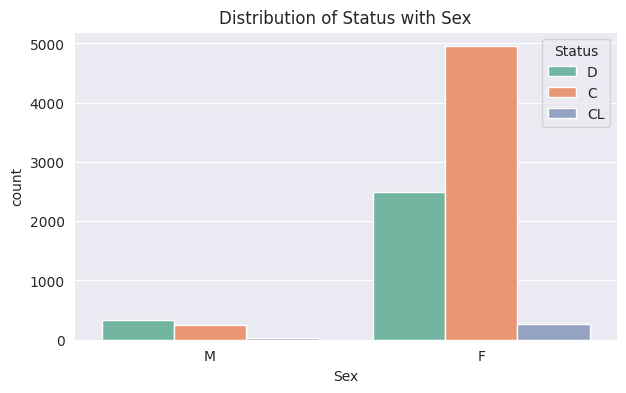

In [21]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Sex', data = train_data, hue='Status', palette = 'Set2')
plt.title('Distribution of Status with Sex')
plt.show()

In [22]:
# Show the count of unique values in the 'Status' column

Uniq_vals = train_data['Status'].value_counts()
Uniq_vals

Status
C     5197
D     2826
CL     300
Name: count, dtype: int64

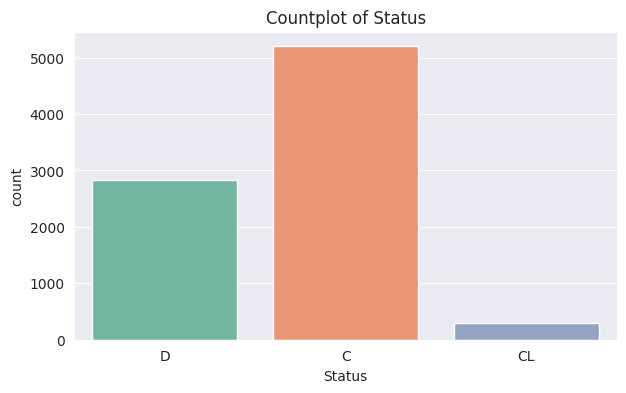

In [23]:
plt.figure(figsize=(7, 4))
sns.countplot(x ='Status', data = train_data, palette = 'Set2')
plt.title('Countplot of Status')
plt.show()

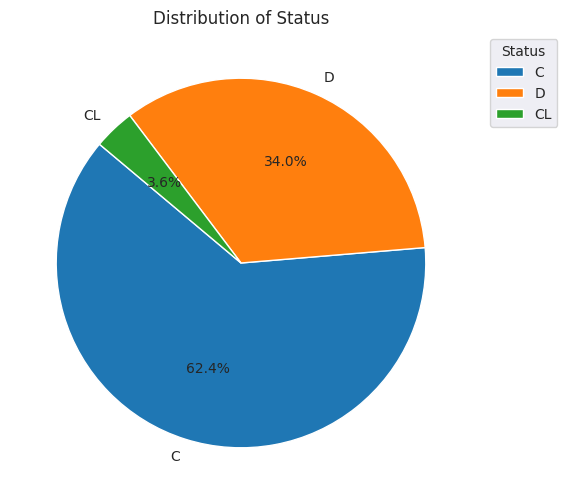

In [24]:
# Plotting the distribution of the target variable 'Status'

LABELS = Uniq_vals.index
y = Uniq_vals.values

# Creating autocpt arguments for pie chart
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%".format(pct)

# Creating the pie chart
plt.figure(figsize=(10, 6))
plt.pie(y, 
        labels = LABELS, 
        autopct = lambda pct: func(pct, Uniq_vals),
        startangle = 140)

plt.legend(loc ='upper right', 
           bbox_to_anchor=(1.2, 1), 
           title='Status')

plt.title('Distribution of Status')
plt.show()

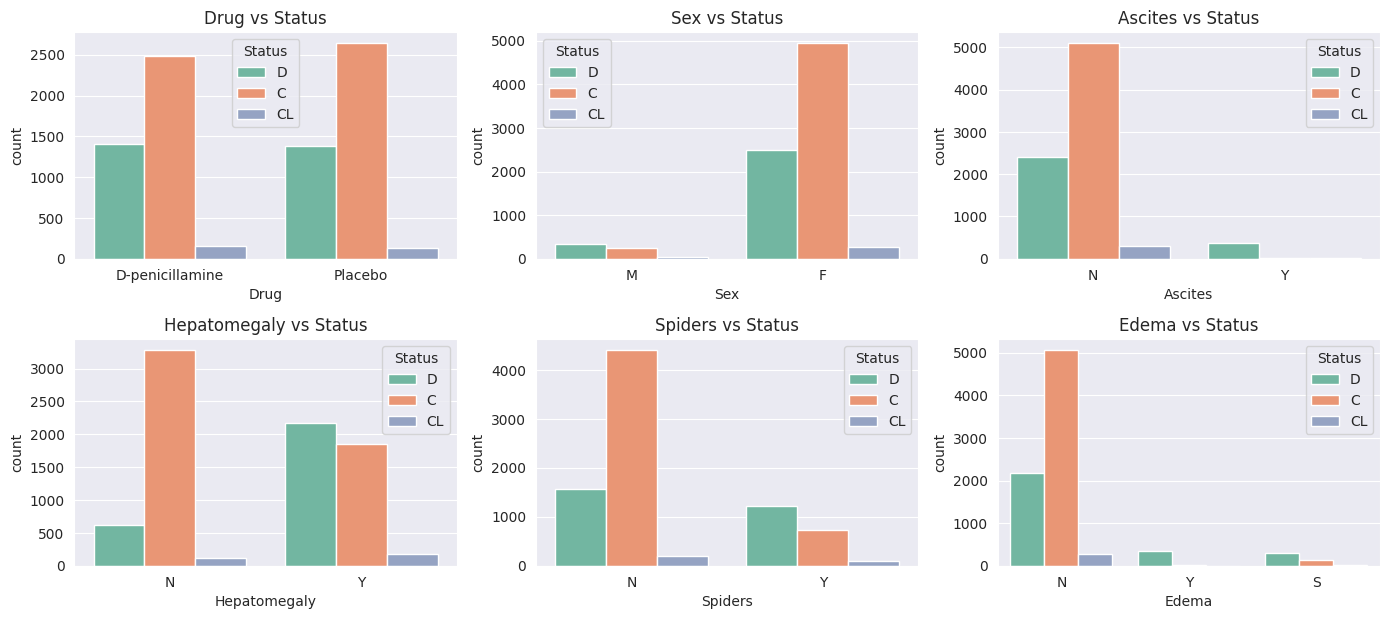

In [25]:
# Plot distribution of target column with categorical features
target = 'Status'
CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

plt.figure(figsize=(14, len(CAT_FEATS) * 2))
for i, col in enumerate(CAT_FEATS):
    plt.subplot(len(CAT_FEATS) // 2 + 1, 3, i + 1)
    sns.countplot(data=train_data, x=col, hue=target, palette = 'Set2')
    plt.title(f"{col} vs {target}")
    plt.tight_layout()

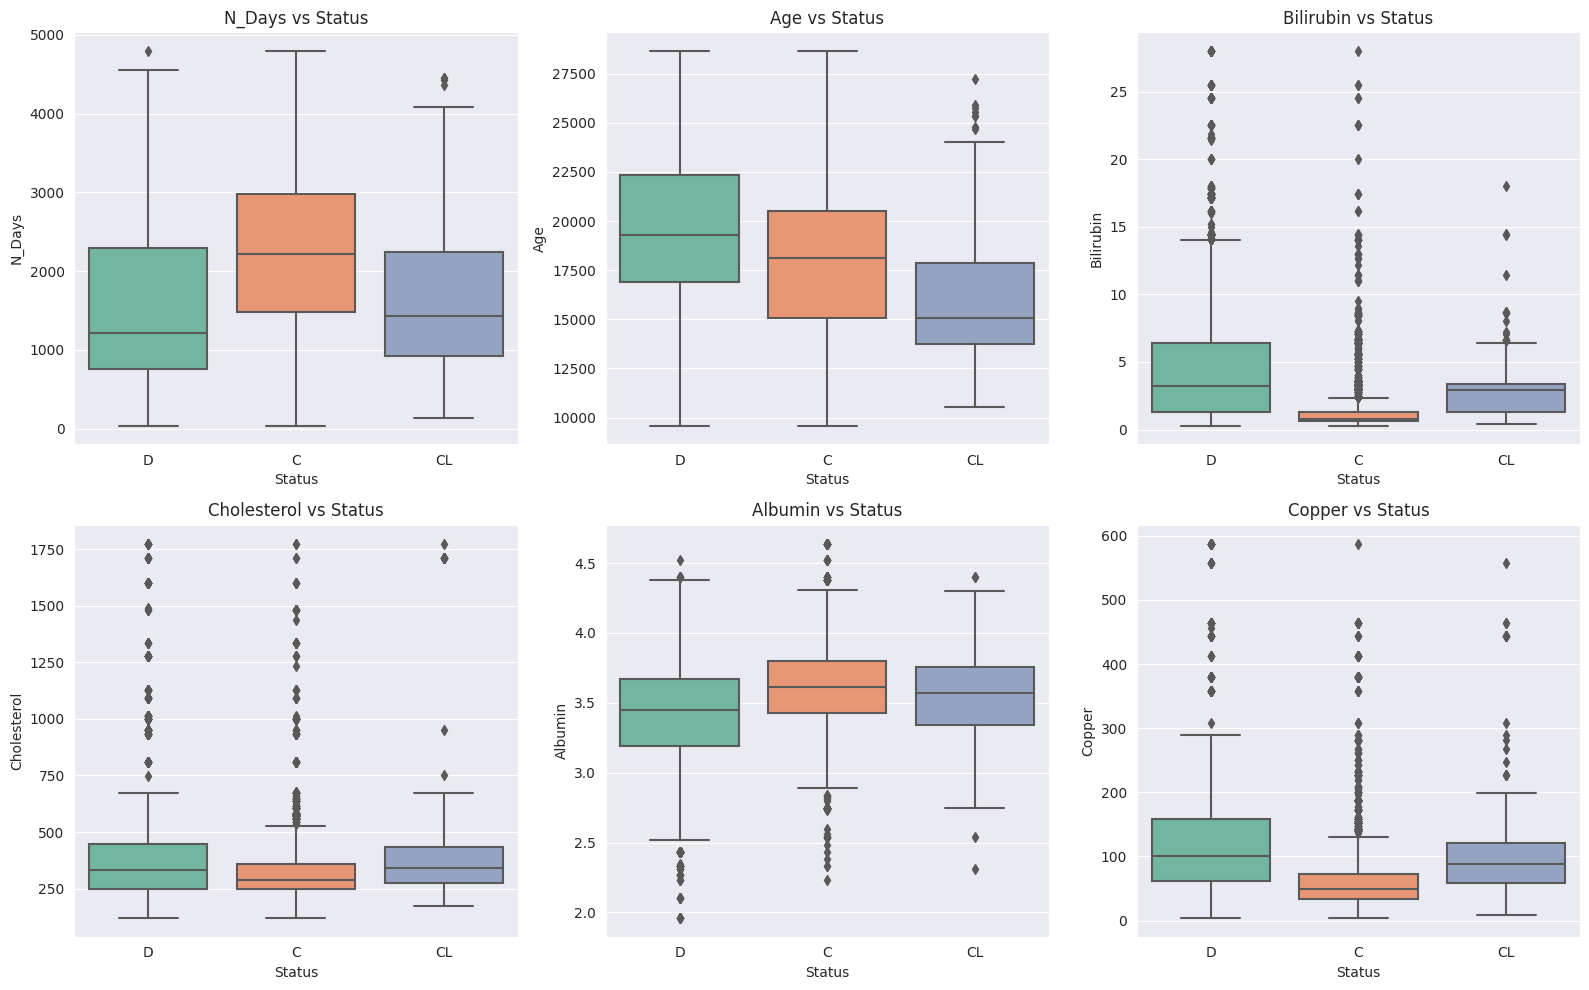

In [26]:
# Plot distribution of target column with numerical features
NUM_FEATS = [x for x in train_data.columns if x not in CAT_FEATS and x != target]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
for i, ax in enumerate(axes.flatten()):
    sns.boxplot(x=target, y=NUM_FEATS[i], data=train_data, ax=ax, palette = 'Set2')
    ax.set_title(f"{NUM_FEATS[i]} vs {target}")
plt.tight_layout()
plt.show()

## Test Data

In [27]:
test.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,7906,2468,D-penicillamine,14975,F,N,N,N,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,7907,51,Placebo,13149,F,N,Y,N,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,7908,2330,D-penicillamine,20510,F,N,N,N,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [28]:
# Check for null values
test.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

# Data Preprocessing

## Data Cleaning 

In [29]:
# Check for null values
train_data.isnull().sum()

N_Days             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
Status             0
dtype: int64

In [30]:
# Features with missing values

miss_feat=['Drug',            # object
           'Ascites',         # object
           'Hepatomegaly',    # object
           'Spiders',         # object
           'Cholesterol',     # float64
           'Copper',          # float64
           'Alk_Phos',        # float64
           'SGOT',            # float64
           'Tryglicerides',   # float64
           'Platelets',       # float64
           'Prothrombin',     # float64
           'Stage']           # float64

len(miss_feat)

12

In [31]:
for feat in miss_feat:
    train_data[feat].fillna(train_data[feat].mode()[0], inplace = True)

In [32]:
train_data.isnull().sum()

N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

## Encoding

### Training Data

In [33]:
encoder = LabelEncoder()

train_data['Drug'] = encoder.fit_transform(train_data['Drug'])
train_data['Sex'] = encoder.fit_transform(train_data['Sex'])
train_data['Ascites'] = encoder.fit_transform(train_data['Ascites'])
train_data['Hepatomegaly'] = encoder.fit_transform(train_data['Hepatomegaly'])
train_data['Spiders'] = encoder.fit_transform(train_data['Spiders'])
train_data['Edema'] = encoder.fit_transform(train_data['Edema'])
train_data['Status'] = encoder.fit_transform(train_data['Status'])

In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8323 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         8323 non-null   int64  
 1   Drug           8323 non-null   int64  
 2   Age            8323 non-null   int64  
 3   Sex            8323 non-null   int64  
 4   Ascites        8323 non-null   int64  
 5   Hepatomegaly   8323 non-null   int64  
 6   Spiders        8323 non-null   int64  
 7   Edema          8323 non-null   int64  
 8   Bilirubin      8323 non-null   float64
 9   Cholesterol    8323 non-null   float64
 10  Albumin        8323 non-null   float64
 11  Copper         8323 non-null   float64
 12  Alk_Phos       8323 non-null   float64
 13  SGOT           8323 non-null   float64
 14  Tryglicerides  8323 non-null   float64
 15  Platelets      8323 non-null   float64
 16  Prothrombin    8323 non-null   float64
 17  Stage          8323 non-null   float64
 18  Status        

### test data

In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5271 entries, 0 to 5270
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5271 non-null   int64  
 1   N_Days         5271 non-null   int64  
 2   Drug           5271 non-null   object 
 3   Age            5271 non-null   int64  
 4   Sex            5271 non-null   object 
 5   Ascites        5271 non-null   object 
 6   Hepatomegaly   5271 non-null   object 
 7   Spiders        5271 non-null   object 
 8   Edema          5271 non-null   object 
 9   Bilirubin      5271 non-null   float64
 10  Cholesterol    5271 non-null   float64
 11  Albumin        5271 non-null   float64
 12  Copper         5271 non-null   float64
 13  Alk_Phos       5271 non-null   float64
 14  SGOT           5271 non-null   float64
 15  Tryglicerides  5271 non-null   float64
 16  Platelets      5271 non-null   float64
 17  Prothrombin    5271 non-null   float64
 18  Stage   

In [36]:
test['Drug'] = encoder.fit_transform(test['Drug'])
test['Sex'] = encoder.fit_transform(test['Sex'])
test['Ascites'] = encoder.fit_transform(test['Ascites'])
test['Hepatomegaly'] = encoder.fit_transform(test['Hepatomegaly'])
test['Spiders'] = encoder.fit_transform(test['Spiders'])
test['Edema'] = encoder.fit_transform(test['Edema'])

## Data Splitting 

In [37]:
X = train_data.drop(['Status'], axis=1)
y = train_data['Status']

In [38]:
RANDOM_SEED = np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_SEED
                                                    )

print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (6658, 18)
X_test shape is  (1665, 18)
y_train shape is  (6658,)
y_test shape is  (1665,)


# Modeling

## Building a baseline model (XGBoost)

In [39]:
# Create the model
XGBModel = XGBClassifier()

# Fit the model
XGBModel.fit(X_train, y_train)

# Make predictions
preds = XGBModel.predict(X_test)

In [40]:
print(f'Predicted values: \n{preds[:10]}')
print(f'True values: \n{y_test[:10]}')

Predicted values: 
[2 2 0 0 0 0 2 0 0 0]
True values: 
7000    0
1346    2
3071    0
5204    0
4952    0
291     0
1728    2
4287    0
7423    0
4482    0
Name: Status, dtype: int64


In [41]:
y_pred_probs = XGBModel.predict_proba(X_test)
print('Log loss for xgb: ', log_loss(y_test, y_pred_probs))

Log loss for xgb:  0.5037218937505533


In [42]:
print("Accuracy:", accuracy_score(y_test, preds)) 
print("Precision:", precision_score(y_test, preds, average="weighted")) 
print('Recall:', recall_score(y_test, preds, average="weighted")) 

Accuracy: 0.8294294294294294
Precision: 0.823145495169898
Recall: 0.8294294294294294


## Building a baseline model (RandomForestClassifier)

In [43]:
# Create the model
RFModel = RandomForestClassifier()

# Fit the model
RFModel.fit(X_train, y_train)

# Make predictions
preds = RFModel.predict(X_test)

In [44]:
print(f'Predicted values: \n{preds[:10]}')
print(f'True values: \n{y_test[:10]}')

Predicted values: 
[0 2 0 0 0 0 2 0 0 0]
True values: 
7000    0
1346    2
3071    0
5204    0
4952    0
291     0
1728    2
4287    0
7423    0
4482    0
Name: Status, dtype: int64


In [45]:
y_pred_probs = RFModel.predict_proba(X_test)
print('Log loss for Random Forest: ', log_loss(y_test, y_pred_probs))

Log loss for Random Forest:  0.512294031279772


In [46]:
print("Accuracy:", accuracy_score(y_test, preds)) 
print("Precision:", precision_score(y_test, preds, average="weighted")) 
print('Recall:', recall_score(y_test, preds, average="weighted")) 

Accuracy: 0.8312312312312312
Precision: 0.8268810268142591
Recall: 0.8312312312312312


## Building a baseline model (CatBoostClassifier)

In [47]:
# Create the model
CatModel = CatBoostClassifier()

# Fit the model
CatModel.fit(X_train, y_train, verbose=256)

# Make predictions
preds = CatModel.predict(X_test)

Learning rate set to 0.087159
0:	learn: 1.0146382	total: 61.9ms	remaining: 1m 1s
256:	learn: 0.3325276	total: 1.26s	remaining: 3.65s
512:	learn: 0.2544772	total: 2.51s	remaining: 2.38s
768:	learn: 0.2018410	total: 3.74s	remaining: 1.12s
999:	learn: 0.1680932	total: 4.86s	remaining: 0us


In [48]:
y_pred_probs = CatModel.predict_proba(X_test)
print('Log loss for Cat Boost: ', log_loss(y_test, y_pred_probs))

Log loss for Cat Boost:  0.4579475965550353


In [49]:
print("Accuracy:", accuracy_score(y_test, preds)) 
print("Precision:", precision_score(y_test, preds, average="weighted")) 
print('Recall:', recall_score(y_test, preds, average="weighted")) 

Accuracy: 0.8378378378378378
Precision: 0.8300316975027572
Recall: 0.8378378378378378


## Hyperparameter tuning for XGBoost

In [50]:
# Create an Optuna objective function
def objective(trial):
    params = {
        "objective": "multi_logloss",
        "n_estimators": trial.suggest_int('n_estimators', 500, 750),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0), 
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0), 
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    # Build the xgboost model
    optuna_xgbmodel = XGBClassifier(**params,
                                    random_state=RANDOM_SEED)
    
    optuna_xgbmodel.fit(X_train, y_train)
    y_pred_probs = optuna_xgbmodel.predict_proba(X_test)
    logloss = log_loss(y_test, y_pred_probs)
    return logloss

# Create the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2023-12-26 14:21:02,307] A new study created in memory with name: no-name-f810f521-ef32-421b-b6fb-bc8a933f0493
[I 2023-12-26 14:21:03,413] Trial 0 finished with value: 0.5182127367221848 and parameters: {'n_estimators': 621, 'learning_rate': 0.011545269256269107, 'max_depth': 2, 'subsample': 0.9793214565523165, 'colsample_bytree': 0.08052192941256042, 'min_child_weight': 6}. Best is trial 0 with value: 0.5182127367221848.
[I 2023-12-26 14:21:05,911] Trial 1 finished with value: 0.476542180184048 and parameters: {'n_estimators': 636, 'learning_rate': 0.005520906922290594, 'max_depth': 7, 'subsample': 0.35864566818678295, 'colsample_bytree': 0.4435262932742671, 'min_child_weight': 16}. Best is trial 1 with value: 0.476542180184048.
[I 2023-12-26 14:21:07,999] Trial 2 finished with value: 0.4815357588673089 and parameters: {'n_estimators': 731, 'learning_rate': 0.005282516250357531, 'max_depth': 4, 'subsample': 0.2839722794974023, 'colsample_bytree': 0.4533178282351612, 'min_child_weig

In [51]:
print('Best hyperparameters:', study.best_params)
print('Best Log Loss:', study.best_value)

Best hyperparameters: {'n_estimators': 650, 'learning_rate': 0.013113221885749505, 'max_depth': 8, 'subsample': 0.8816153967641931, 'colsample_bytree': 0.3317658863527509, 'min_child_weight': 4}
Best Log Loss: 0.42436419455901137


In [52]:
# Best hyperparameters from optuna
params = {'n_estimators': 607, 
          'learning_rate': 0.04191844445257235, 
          'max_depth': 6, 
          'subsample': 0.7079706225468251, 
          'colsample_bytree': 0.16799013289247494, 
          'min_child_weight': 17}

# Create the model
XGBModel_2 = XGBClassifier(**params, random_state=RANDOM_SEED)

In [53]:
# Fit the model
XGBModel_2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.16799013289247494, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04191844445257235,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=607, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [54]:
# Make predictions on test set
preds = XGBModel_2.predict(X_test)

In [55]:
print(f'Predicted values: \n{preds[:10]}')
print(f'True values: \n{y_test[:10]}')

Predicted values: 
[2 2 0 0 0 0 2 0 0 0]
True values: 
7000    0
1346    2
3071    0
5204    0
4952    0
291     0
1728    2
4287    0
7423    0
4482    0
Name: Status, dtype: int64


In [56]:
y_pred_probs = XGBModel_2.predict_proba(X_test)
print('Log loss for tuned xgb: ', log_loss(y_test, y_pred_probs))

Log loss for tuned xgb:  0.42320414005512835


In [57]:
print("Accuracy:", accuracy_score(y_test, preds)) 
print("Precision:", precision_score(y_test, preds, average="weighted")) 
print('Recall:', recall_score(y_test, preds, average="weighted")) 

Accuracy: 0.8342342342342343
Precision: 0.8281365321766991
Recall: 0.8342342342342343


# Submission

In [58]:
# Fit the model on entire data
XGBModel_2.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.16799013289247494, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04191844445257235,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=607, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
test_IDs = test['id']
test = test.drop(['id'], axis=1)

In [60]:
# Make predictions on test data 
y_pred_probs = XGBModel_2.predict_proba(test)
assert y_pred_probs.shape == (test.shape[0], 3)

submission_labels = ["Status_C", "Status_CL", "Status_D"]

submission = pd.DataFrame(
                {"id": test_IDs, **dict(zip(submission_labels, y_pred_probs.T))}
)

submission.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.396452,0.030772,0.572776
1,7906,0.417996,0.299414,0.282591
2,7907,0.009435,0.006295,0.984271
3,7908,0.980863,0.003076,0.016061
4,7909,0.854353,0.068162,0.077484


In [61]:
# Save a submission to csv file
submission.to_csv('submission.csv', index=False)